In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def plot_imageset(images, figsize=(16, 12), nrows_ncols=(4,4), filename=""):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=nrows_ncols, axes_pad=0.1)

    for ax, im in zip(grid, images):
        ax.set_axis_off()
        if len(im.shape) < 3:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    if filename != "":
        plt.savefig(filename, dpi=170)
    else:
        plt.show()

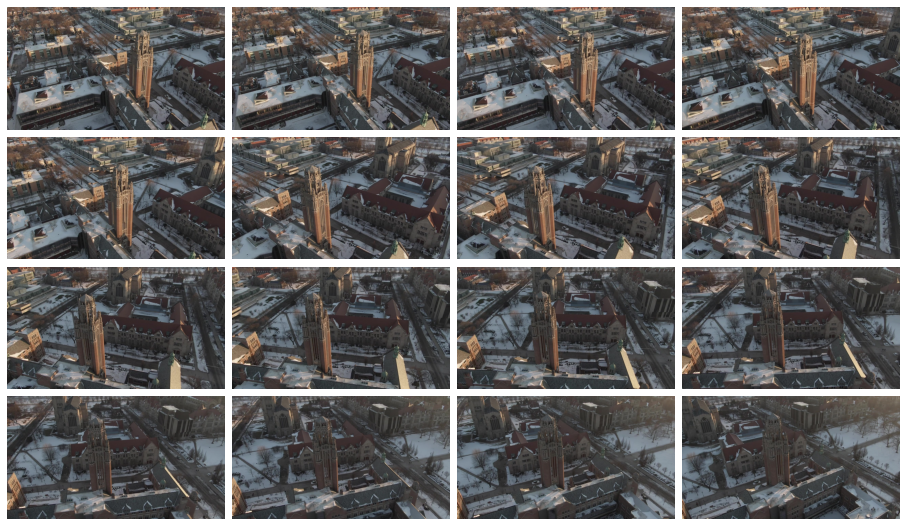

In [5]:
multi_view_image_paths = sorted(glob.glob("data/online/DJI1280/images/*.jpg"))
multi_view_images = [cv2.imread(path) for path in multi_view_image_paths]
plot_imageset(multi_view_images)

In [6]:
multi_view_images[0].shape

(720, 1280, 3)

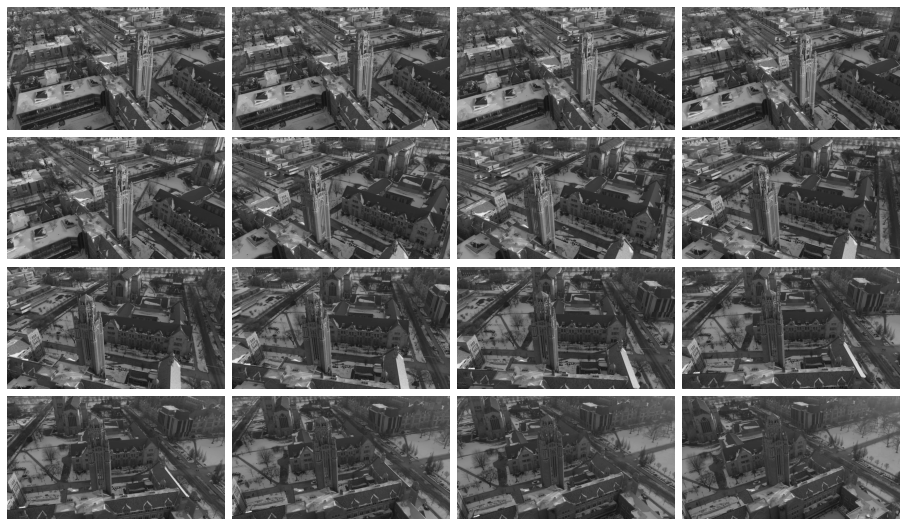

In [7]:
# Convert to gray scale
gray_multi_view_images = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in multi_view_images]
plot_imageset(gray_multi_view_images)

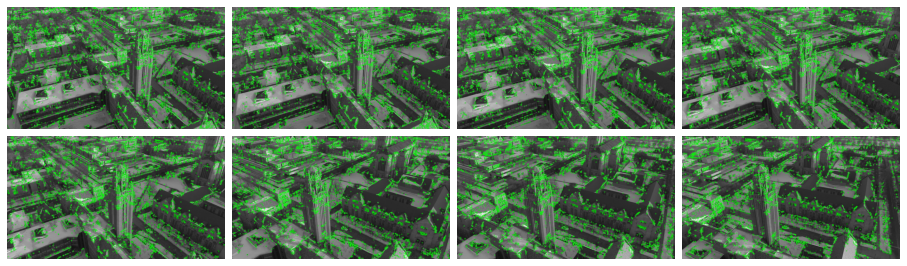

In [8]:
# Detect Features
# orb = cv2.ORB_create()
sift = cv2.SIFT_create()
keypoints = []
descriptors = []
for im in gray_multi_view_images:
    keypoint, descriptor = sift.detectAndCompute(im, None)
    keypoints.append(keypoint)
    descriptors.append(descriptor)
results = []
for i, cur_img in enumerate(gray_multi_view_images):
    p_cur = cv2.drawKeypoints(cur_img, keypoints[i], None, color=(0,255,0))
    results.append(p_cur)
plot_imageset(results, nrows_ncols=(2, 4), filename="features.png")

0 - 1:,  [10.440306663513184, 11.958260536193848, 12.247448921203613, 13.82027530670166, 14.03566837310791, 14.866068840026855, 15.0, 15.033296585083008, 15.394804000854492, 15.68438720703125]
0 - 2:,  [16.852298736572266, 17.804492950439453, 18.466184616088867, 19.209373474121094, 21.51743507385254, 22.516660690307617, 22.56102752685547, 23.237899780273438, 23.64318084716797, 24.1867733001709]
0 - 3:,  [19.05255889892578, 26.77685546875, 27.12932014465332, 27.422618865966797, 27.838821411132812, 28.0, 28.23118782043457, 29.18903923034668, 29.393877029418945, 30.049959182739258]
0 - 4:,  [27.184555053710938, 29.20616340637207, 31.032241821289062, 34.219879150390625, 35.958309173583984, 36.18010330200195, 36.715118408203125, 37.496665954589844, 37.947330474853516, 38.96152114868164]
1 - 2:,  [17.20465087890625, 19.570384979248047, 19.899747848510742, 20.248456954956055, 21.494184494018555, 21.931713104248047, 22.759613037109375, 22.781572341918945, 22.89104652404785, 24.103940963745117]

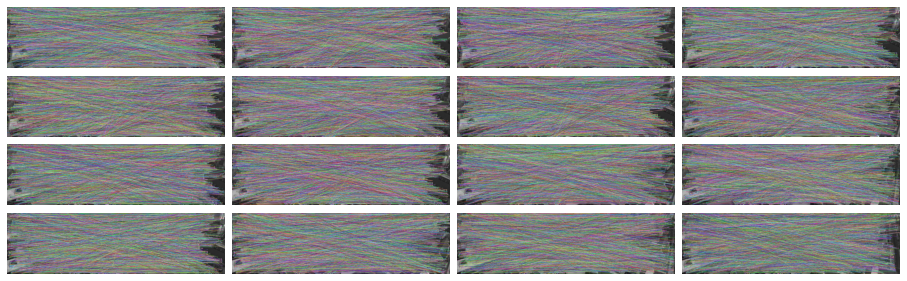

In [9]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

all_matches = []
match_imgs = []
n = len(gray_multi_view_images)
for i in range(n):
    matches_for_i = {}
    for j in range(i+1, i+5):
        matches = bf.match(descriptors[i], descriptors[j % n])
        matches = sorted(matches, key=lambda x: x.distance)
        print(f"{i} - {j}:, ", [x.distance for x in matches[:10]])
        result = cv2.drawMatches(gray_multi_view_images[i], keypoints[i], gray_multi_view_images[j %n], keypoints[j%n], matches, None, flags=2)
        # result = cv2.drawMatchesKnn(gray_multi_view_images[i], keypoints[i], gray_multi_view_images[j %n], keypoints[j%n], good, flags=2)
        match_imgs.append(result)
        matches_for_i[j%n] = matches
    all_matches.append(matches_for_i)

plot_imageset(match_imgs)


In [10]:
from run1 import Engine
eng = Engine(1280,720, 83)

THE K [[ 9.6e+02 -2.0e-02  6.4e+02  0.0e+00]
 [ 0.0e+00  9.6e+02  3.6e+02  0.0e+00]
 [ 0.0e+00  0.0e+00  1.0e+00  0.0e+00]]


In [11]:
def pnp_calibration(pts_2d, pts_3d):
    # your code here
    n = pts_2d.shape[0]
    A = np.zeros((2 * n, 12))
    for i in range(n):
        x, y = pts_2d[i, 0], pts_2d[i, 1]
        X, Y, Z = pts_3d[i, 0], pts_3d[i, 1], pts_3d[i, 2]
        A[2 * i, :] = [X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x]
        A[2 * i + 1, :] = [0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y]
    U, S, V = np.linalg.svd(A)
    P = V[-1, :].reshape(3, 4)
    P = P / P[2, 3]
    return P

In [12]:


def recover_3d_from_one_match(all_matches, i, j):
    match = all_matches[i][j]
    # good = []
    # for m,n in match:
    #     if m.distance < 0.7*n.distance:
    #         good.append(m)
    # good = np.array(good)
    # print(good.shape)
    print(match[10].distance)
    # print(match[0])

    src_pts = np.float32([ keypoints[i][m.queryIdx].pt for m in match ])
    dst_pts = np.float32([ keypoints[j][m.trainIdx].pt for m in match ])
    
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    print("cv2 F", F)
    src_pts = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    dst_pts = np.hstack((dst_pts, np.ones((dst_pts.shape[0], 1))))
    print(src_pts.shape, dst_pts.shape)
    src_cleared = []
    dst_cleared = []
    good = []
    print(len(match))
    # print(match)
    for k in range(len(matchesMask)):
        if matchesMask[k] == 1:
            src_cleared.append(src_pts[k])
            dst_cleared.append(dst_pts[k])
            good.append(match[k])
    src_cleared = np.array(src_cleared)
    dst_cleared = np.array(dst_cleared)
    print("src_cleared 10", src_cleared[:10])
    print("dst_cleared 10", dst_cleared[:10])
    # print(len(good))
    # # print(src_cleared)
    print(src_cleared.shape, dst_cleared.shape)
    draw_params = dict(#matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(gray_multi_view_images[i],keypoints[i],gray_multi_view_images[j],keypoints[j],good,None)
    plot_imageset([img3], figsize=(12,12), nrows_ncols=(1,1), filename="match0-4.png") 
    p1, p2, pts =  eng.sfm_pipeline_for_project(src_cleared, dst_cleared, src_cleared, dst_cleared, F=F, use_BA = True, draw_config=True, final_vis=False)
    return p1, p2, pts, src_cleared, dst_cleared
    

30.72458267211914
cv2 F [[-1.51356879e-06  1.59178670e-04  1.24292298e-02]
 [-1.60708130e-04 -7.86570944e-06  8.89779666e-02]
 [-1.08798804e-02 -6.95545494e-02  1.00000000e+00]]
(7059, 3) (7059, 3)
7059
src_cleared 10 [[7.01170593e+02 5.35406921e+02 1.00000000e+00]
 [8.54327698e+02 2.72653473e+02 1.00000000e+00]
 [8.54327698e+02 2.72653473e+02 1.00000000e+00]
 [1.10316833e+03 4.58912842e+02 1.00000000e+00]
 [1.03550427e+03 1.12931786e+02 1.00000000e+00]
 [6.62950562e+02 1.08237885e+02 1.00000000e+00]
 [6.19852905e+02 2.14533371e+02 1.00000000e+00]
 [5.82372803e+02 8.30380096e+01 1.00000000e+00]
 [5.99169128e+02 9.17394485e+01 1.00000000e+00]
 [6.49325562e+02 6.49355011e+01 1.00000000e+00]]
dst_cleared 10 [[6.20382568e+02 5.74387268e+02 1.00000000e+00]
 [7.54998718e+02 2.76694824e+02 1.00000000e+00]
 [7.54998718e+02 2.76694824e+02 1.00000000e+00]
 [1.01521112e+03 4.60666138e+02 1.00000000e+00]
 [9.19915894e+02 1.08934349e+02 1.00000000e+00]
 [5.52985046e+02 1.14336922e+02 1.00000000e+00

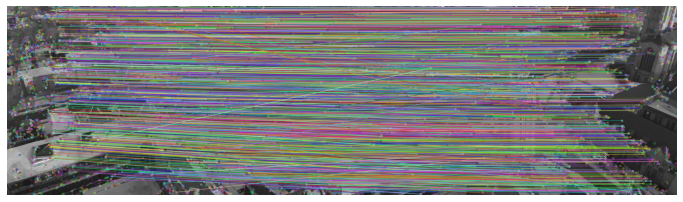

In [13]:
p1, p2, pts, last_2d_pts, last_2d_dst = recover_3d_from_one_match(all_matches, 2, 4)
pts_old, pts, mask = eng.filter_pts(p1, p2, pts)
# pts_1 = pts_old[:, :3]
# mask3 = (np.abs(pts_1) > 100).any(axis=1)
# mask = np.bitwise_and(mask, ~mask3)
# pts = pts_old[mask, :]
all_pts = pts.copy()
camera_poses = [p1, p2]
last_mask = mask
last_2d_pts123 = last_2d_pts[last_mask, :]
last_2d_dst123 = last_2d_dst[last_mask, :]
print(last_2d_pts123.shape)
print(last_2d_dst123.shape)

In [26]:
pts1111 = pts / pts[:, -1].reshape(-1,1)
print(pts1111[:10])

[[ -0.86570018  -2.5112123  -13.81846668   1.        ]
 [ -6.82746593   2.7932105  -30.68145021   1.        ]
 [ -6.82746593   2.7932105  -30.68145021   1.        ]
 [ -8.20680638  -1.74895518 -17.0876218    1.        ]
 [-18.01954952  11.27712085 -43.79739169   1.        ]
 [ -0.88953907   9.85351021 -37.59858628   1.        ]
 [  0.73641852   5.20700387 -34.38636525   1.        ]
 [  2.48855129  11.94751868 -41.4408072    1.        ]
 [  1.61480699  10.57383038 -37.86946312   1.        ]
 [ -0.39017101  12.45753349 -40.55445634   1.        ]]


[[ 0.99340159 -0.05060668  0.10291867  0.06523897]
 [ 0.05062793  0.99871468  0.00240745  0.40791621]
 [-0.10290822  0.00281899  0.99468686 -0.84250571]
 [ 0.          0.          0.          1.        ]]


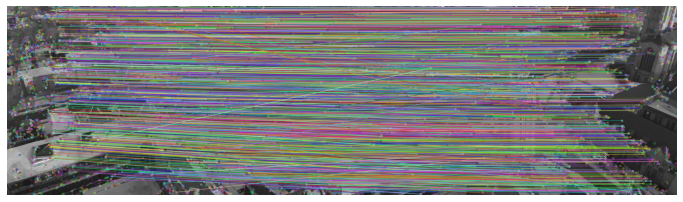

In [12]:
print(p2)

In [22]:
print(p1)

[[ 9.99999851e-01  4.03605985e-04  3.66782444e-04  1.56779046e-02]
 [-4.03526724e-04  9.99999895e-01 -2.16147480e-04 -3.08632716e-04]
 [-3.66869644e-04  2.15999441e-04  9.99999909e-01 -5.89957186e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [34]:
print(pts.shape)

(3033, 4)


In [34]:
print(camera_poses)

[array([[ 9.99999886e-01, -3.68071831e-04, -3.05800747e-04,
         6.15981662e-02],
       [ 3.67990073e-04,  9.99999897e-01, -2.67373090e-04,
        -7.96055462e-03],
       [ 3.05899128e-04,  2.67260528e-04,  9.99999917e-01,
         6.55755633e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), array([[ 9.99550467e-01, -1.27233964e-02,  2.71473433e-02,
         7.49186805e-01],
       [ 1.27518146e-02,  9.99918310e-01, -8.73941664e-04,
        -1.60739456e-01],
       [-2.71340061e-02,  1.21972669e-03,  9.99631061e-01,
         5.62017635e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [14]:
eng.visualize_final_view(pts, camera_poses)

[Open3D DEBUG] Add geometry and update bounding box to [(-30.2026, -5.3530, -302.6631) - (90.3344, 107.7416, -1.1774)]
[Open3D DEBUG] Add geometry and update bounding box to [(-30.2026, -5.3530, -302.6631) - (90.3344, 107.7416, 0.2411)]
[Open3D DEBUG] Add geometry and update bounding box to [(-30.2026, -5.3530, -302.6631) - (90.3344, 107.7416, 0.2411)]


In [14]:
from sfm import pose_pair_from_t_and_R


src_pts = np.float32([ keypoints[4][m.queryIdx].pt for m in all_matches[4][6] ])
dst_pts = np.float32([ keypoints[6][m.trainIdx].pt for m in all_matches[4][6] ])
F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()


src_pts = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
dst_pts = np.hstack((dst_pts, np.ones((dst_pts.shape[0], 1))))
src_cleared = []
dst_cleared = []
for j in range(len(matchesMask)):
    if matchesMask[j] == 1:
        src_cleared.append(src_pts[j])
        dst_cleared.append(dst_pts[j])
src_cleared = np.array(src_cleared)
dst_cleared = np.array(dst_cleared)

print(src_cleared.shape, dst_cleared.shape)
matching_previous_2d = []
matching_previous_pts = []

# last_2d_pts = last_2d_pts[last_mask, :]
for j, last2dpt in enumerate(last_2d_dst123):
    for k, cur2dpt in enumerate(src_cleared):
        if np.array_equal(cur2dpt, last2dpt):
            matching_previous_2d.append(cur2dpt)
            matching_previous_pts.append(pts[j])

print(len(matching_previous_2d))
matching_previous_2d = np.array(matching_previous_2d)
matching_previous_pts = np.array(matching_previous_pts)
if(len(matching_previous_2d) < 10):
    print("not enough common pts found when i =", i)
else:
    P = pnp_calibration(matching_previous_2d, matching_previous_pts)
    # p2 = cv2.solvePnP(matching_previous_pts, matching_previous_2d, eng.K[:3, :3], 
    R_t = np.linalg.inv(eng.K[:3, :3]) @ P # 3* 4
    R = R_t[:, :3]
    t = R_t[:, 3]
    p1_rec, p2_rec = pose_pair_from_t_and_R(t, R)
    # 3 * 4
    # registered the new camera
    # compute the new 3D points
    x1s = src_cleared
    x2s = dst_cleared
    p1, p2, pts = eng.sfm_addcamera(p1=p2, p2=p2_rec, x1s=src_cleared, x2s=dst_cleared)
    pts_old, pts, mask = eng.filter_pts(p1, p2, pts)
    camera_poses.append(p2)
    last_2d_pts = dst_cleared
    last_mask = mask
    all_pts = np.vstack((all_pts, pts))

 

(1228, 3) (1228, 3)
853
R.shape (3, 3)
t.shape (3,)
stack p2 [[ 7.20001520e-01 -4.07787571e-02  7.21281499e-02 -2.88799248e-03]
 [ 4.05421435e-02  7.17127639e-01 -1.42370034e-04  3.47233466e-01]
 [-8.32515354e-02  1.28298800e-02  7.24246300e-01 -7.28381278e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
sfm P1 [[ 1.01953448e+03  5.01236014e+01  5.37807647e+02  3.66146406e+02]
 [-1.15316912e+01  9.59632777e+02  3.60793505e+02 -8.67268588e+01]
 [ 1.02918667e-01  2.40744906e-03  9.94686861e-01  8.30333013e-01]]
sfm P2 [[ 1.41542745e+03  6.71711271e+01  7.42727163e+02  5.21752241e+02]
 [-1.71192437e+01  1.32877230e+03  4.99034592e+02 -9.79561990e+01]
 [ 1.58690523e-01 -1.53958598e-02  1.36493863e+00  1.00000000e+00]]
sfm P None
step 0, err: 934.2000071103377
step 1000, err: 59.59721625642189
step 2000, err: 56.51387918399374
step 3000, err: 55.187689417889736
step 4000, err: 54.388143305570246
step 5000, err: 53.51055986724544
step 6000, err: 53.01820802993882
step

In [15]:
eng.visualize_final_view(all_pts, camera_poses)

[Open3D DEBUG] Add geometry and update bounding box to [(-104.6350, -14.4316, -465.7243) - (90.3344, 162.6641, 1.1078)]
[Open3D DEBUG] Add geometry and update bounding box to [(-104.6350, -14.4316, -465.7243) - (90.3344, 162.6641, 1.1078)]
[Open3D DEBUG] Add geometry and update bounding box to [(-104.6350, -14.4316, -465.7243) - (90.3344, 162.6641, 1.1078)]
[Open3D DEBUG] Add geometry and update bounding box to [(-104.6350, -14.4316, -465.7243) - (90.3344, 162.6641, 1.1078)]
[Open3D DEBUG] [Visualizer] Screen capture to ScreenCapture_2022-03-16-16-36-53.png
[Open3D DEBUG] [Visualizer] Screen camera capture to ScreenCamera_2022-03-16-16-36-53.json
